# Quantity — Outlier Detection → Decision → Rescaling

This notebook executes a **five-step pipeline** for the numerical feature **Quantity**:

1. **Choose feature** (why `Quantity` first in pipeline)  
2. **Detect outliers** with statistical evidence (IQR rule + metrics)  
3. **Decide** to keep / winsorize / transform (data-driven, not just theory)  
4. **Rescale** the cleaned feature (Normalization, Standardization, Robust Scaling) and save outputs
5. **Visual** show histograms comparing original vs cleaned `Quantity`


## 1) Choose which feature to do first — `Quantity`
**Why `Quantity` first?**
- It is a **discrete count** and often shows **right-skew** (many small purchases, few large bulk orders).
- Bulk outliers can **inflate the standard deviation** and distort scaling if left untreated.
- Treating `Quantity` first stabilizes subsequent scaling and downstream models.


In [110]:
# === Import lib ===
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [111]:
# Input and output files
CSV_IN = "../output_data/5_category/encoded_category_dataset.csv"
CSV_OUT = "../scaled_output_data/1_quantity/scaled_quantity_dataset.csv"

QUANTITY = "Quantity"

In [112]:
# Load dataset
# Read the CSV file into a DataFrame
# pd.read_csv loads the data from CSV_IN to df
df = pd.read_csv(CSV_IN)

# .to_numeric converts the Quantity column to numeric, coercing errors to NaN
df[QUANTITY] = pd.to_numeric(df[QUANTITY], errors="coerce")

# Display the number of rows and the first 10 entries of the Quantity column for verification
print("Rows:", len(df))
display(df[[QUANTITY]].head(10))

Rows: 11971


,Quantity
0,5.0
1,5.0
2,9.0
3,3.0
4,5.0
5,3.0
6,6.0
7,1.0
8,8.0
9,5.0


## 2) Detect outliers (IQR)
We compute **Q1, Q3, IQR** and the **fences**:  
- Lower fence = Q1 − 1.5×IQR  
- Upper fence = Q3 + 1.5×IQR  

In [ ]:
# === IQR computation & flags ===
# Calculate Q1, Q3, IQR, lower and upper fences
q1 = df[QUANTITY].quantile(0.25) # 25th percentile
q3 = df[QUANTITY].quantile(0.75) # 75th percentile
iqr = q3 - q1 # Interquartile Range (IQR)
lower = q1 - 1.5*iqr # Lower fence
upper = q3 + 1.5*iqr # Upper fence

# Detect outliers
isOutlier = (df[QUANTITY] < lower) | (df[QUANTITY] > upper) # Boolean Series contain outliers with True value is outlier
outlierCount = int(isOutlier.sum()) # Count of outliers
total = len(df) # Total number of entries
# Percentage of outliers in the feature
pctOutliers = (outlierCount/total*100.0) if total else 0.0  # if total is 0, set pctOutliers to 0.0 to avoid division by zero

mean = df[QUANTITY].mean() 
median = df[QUANTITY].median()
std = df[QUANTITY].std() # Standard Deviation
skew = df[QUANTITY].skew() # Skewness
kurt = df[QUANTITY].kurt() # Kurtosis

# summary statistics
summary = pd.Series({ # Summary is a Series object containing various statistics
    "Q1": q1, "Q3": q3, "IQR": iqr,
    "LowerFence": lower, "UpperFence": upper,
    "Outliers": outlierCount, "Outliers %": pctOutliers,
    "Mean": mean, "Median": median, "Std": std,
    "Skewness": skew, "Kurtosis": kurt
})
display(summary.round(4))

# Print outlier detection results with IQR method
if outlierCount > 0:
    print(f"Detected {outlierCount} outliers ({pctOutliers:.2f}%) in '{QUANTITY}' feature.")
else:
    print(f"No outliers detected in '{QUANTITY}' feature.")

Q1             3.0000
Q3             8.0000
IQR            5.0000
LowerFence    -4.5000
UpperFence    15.5000
Outliers       0.0000
Outliers %     0.0000
Mean           5.5364
Median         6.0000
Std            2.8579
Skewness      -0.0119
Kurtosis      -1.2088
dtype: float64

No outliers detected in 'Quantity' feature.


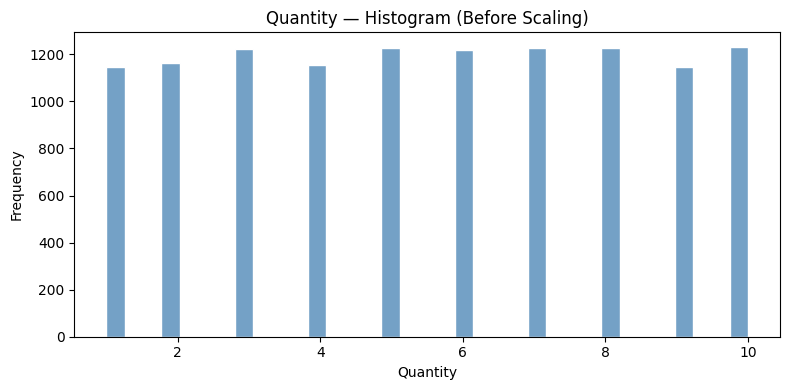

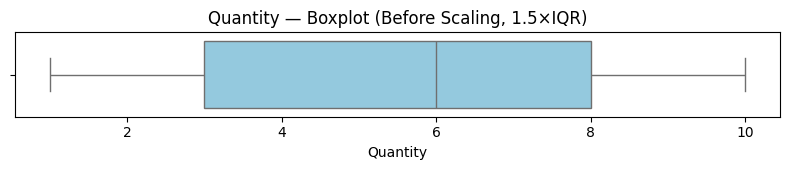

In [114]:
# Visuals: Histogram & Boxplot
# Histogram (before scaling)
plt.figure(figsize=(8, 4))
sns.histplot(
    df[QUANTITY],
    bins=35,
    edgecolor="white",
    color="steelblue"
)
plt.title("Quantity — Histogram (Before Scaling)")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot (before scaling)
plt.figure(figsize=(8, 1.8))
sns.boxplot(
    x=df[QUANTITY],
    color="skyblue",
    whis=1.5  # matches the IQR rule
)
plt.title("Quantity — Boxplot (Before Scaling, 1.5×IQR)")
plt.xlabel("Quantity")
plt.tight_layout()
plt.show()

### Why IQR here
- The IQR method is chosen because it’s non-parametric, it resists outlier influence, and it keeps the Quantity feature steady even when a few very large transactions appear.-


## 3) Decide: remove, transform, or keep outliers
No outliers flagged for Quantity by the 1.5×IQR rule, so the observed range sits comfortably within the usual variability band. With nothing breaching the lower or upper fences, we can leave the column untouched—no trimming, capping. This also means downstream statistics and models won’t be distorted by extreme records, so the current data stays exactly as collected.

## 4) Rescale the feature
- **Min–Max scaling** for Quantity because the cleaned data already sits in a tight, finite range with no outliers after the IQR check
- Since there’s no heavy skew left and the range is well behaved, more robust methods (robust scaler, log transform) aren’t necessary

In [ ]:
# Rescaling on the cleaned series
quantityList = df[QUANTITY].astype(float)

# Min-Max
min_x, max_x = quantityList.min(), quantityList.max() # find min and max value of the feature
df["Quantity_Norm_MinMax"] = (quantityList - min_x) / (max_x - min_x) if max_x > min_x else 0.0 # if max_x > min_x then do the scaling else 0.0

display(df[["Quantity","Quantity_Norm_MinMax"]].head())

print("\nScaled feature summaries:")
display(df[["Quantity_Norm_MinMax"]].describe().round(4))

,Quantity,Quantity_Norm_MinMax
0,5.0,0.444444
1,5.0,0.444444
2,9.0,0.888889
3,3.0,0.222222
4,5.0,0.444444



Scaled feature summaries:


,Quantity_Norm_MinMax
count,11971.0000
mean,0.5040
std,0.3175
min,0.0000
25%,0.2222
50%,0.5556
75%,0.7778
max,1.0000


## Visuals — Scaled Feature Distributions
Visualize the **scaled versions** of the cleaned feature to confirm their shapes and ranges:

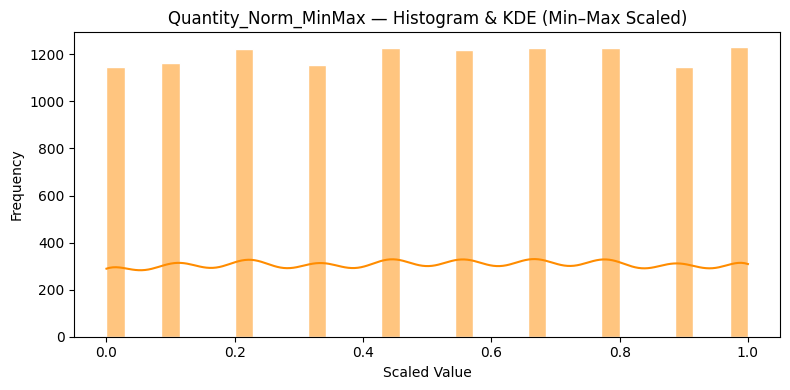

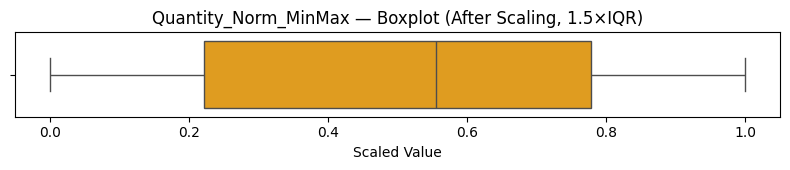

In [117]:
# Histogram + KDE for Min–Max scaled Quantity
scaledCol = "Quantity_Norm_MinMax"
plt.figure(figsize=(8, 4))
sns.histplot(
    df[scaledCol],
    bins=35,
    kde=True,
    color="darkorange",
    edgecolor="white"
)
plt.title(f"{scaledCol} — Histogram & KDE (Min–Max Scaled)")
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot after Min–Max scaling
plt.figure(figsize=(8, 1.8))
sns.boxplot(
    x=df[scaledCol],
    color="orange",
    whis=1.5
)
plt.title(f"{scaledCol} — Boxplot (After Scaling, 1.5×IQR)")
plt.xlabel("Scaled Value")
plt.tight_layout()
plt.show()

- X-axis: the rescaled values ranging from 0 to 1 (0 corresponds to the original minimum quantity, 1 to the original maximum).
- Y-axis: how many rows fall into each bin.
- The KDE curve (orange line) runs nearly flat, confirming that the scaled values are spread fairly evenly with no sharp spikes.

- The gold box shows the middle 50% of values—roughly from 0.25 to 0.75—with the median (bold line) around 0.55.
- The whiskers extend to about 0.0 and 1.0 using the 1.5×IQR rule, so every value falls inside, meaning no outliers remain after scaling.
- The scaled quantity distribution is well-balanced and stays within [0, 1]; Min–Max scaling didn’t create any new outliers.

In [118]:
# Save outputs
df.to_csv(CSV_OUT, index=False)
print("Saved:", CSV_OUT)

Saved: ../scaled_output_data/1_quantity/scaled_quantity_dataset.csv
